In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42)

In [ ]:
# Provide the filename of your Excel file
file_name = 'uu_preprocessed.xlsx'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_name)

#Splitting data into answers for skills test

In [ ]:
#Splitting data into answers for skills test
skills = df[df['maingroup'] == 'Competenties']
len(skills.answer.unique())

# Above gives: array(['content', 'process', 'socialskills', 'complexproblemsolving',
#       'technicalskills', 'systemskills', 'resourcemanagementskills'],

7

In [ ]:
# Specify the column names you want to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the DataFrame using the specified columns
sk = skills.loc[:, columns_to_keep]

sk = sk.drop(['maingroup'], axis=1)
qs = sk.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

count_cont = 1
count_p = 1
count_so = 1
count_cp = 1
count_t = 1
count_sy = 1
count_rm = 1
for index, row in qs.iterrows():
    if row['level1subgroup'] == 'content':
        qs.at[index, 'short_name'] = f'cont{count_cont}'
        count_cont += 1

    elif row['level1subgroup'] == 'process':
        qs.at[index, 'short_name'] = f'pro{count_p}'
        count_p += 1

    elif row['level1subgroup'] == 'socialskills':
        qs.at[index, 'short_name'] = f'scs{count_so}'
        count_so += 1

    elif row['level1subgroup'] == 'complexproblemsolving':
        qs.at[index, 'short_name'] = f'cps{count_cp}'
        count_cp += 1

    elif row['level1subgroup'] == 'technicalskills':
        qs.at[index, 'short_name'] = f'tec{count_t}'
        count_t += 1

    elif row['level1subgroup'] == 'systemskills':
        qs.at[index, 'short_name'] = f'sys{count_sy}'
        count_sy += 1

    else:
        qs.at[index, 'short_name'] = f'rms{count_rm}'
        count_rm += 1
qs

,question_id,level1subgroup,short_name
674,2551,complexproblemsolving,cps1
663,2540,content,cont1
662,2539,content,cont2
658,2535,content,cont3
660,2537,content,cont4
659,2536,content,cont5
661,2538,content,cont6
664,2541,process,pro1
665,2542,process,pro2
666,2543,process,pro3


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(skills, n_qs, on='question_id', how='left')
new_qs.head(3)

,dossier_id,question_id,answer,label,maingroup,maingroup_id,level1subgroup,level1subgroup_id,faculty,short_name
0,2112,2535,0.666667,"Ik heb uitstekend inzicht in geschreven tekst,...",Competenties,525.0,content,\N,Faculteit Geesteswetenschappen,cont3
1,2112,2536,0.833333,Ik ben erg goed in het geven van volledige aan...,Competenties,525.0,content,\N,Faculteit Geesteswetenschappen,cont5
2,2112,2537,0.666667,Ik kan uitstekend schriftelijk communiceren al...,Competenties,525.0,content,\N,Faculteit Geesteswetenschappen,cont4


In [ ]:
# Create pivot table for Questions
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset the index of 'qs_data'
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)

# Remove NAN values
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,cont1,cont2,cont3,cont4,cont5,cont6,cps1,pro1,pro2,...,tec1,tec10,tec2,tec3,tec4,tec5,tec6,tec7,tec8,tec9
0,2112,0.166667,0.166667,0.666667,0.666667,0.833333,0.500000,0.500000,0.666667,0.833333,...,0.166667,0.333333,0.500000,0.166667,0.166667,0.000000,0.000000,0.500000,0.500000,0.000000
1,42916,0.666667,0.666667,0.500000,0.500000,0.666667,0.333333,0.333333,0.500000,0.166667,...,0.500000,0.500000,0.500000,0.333333,0.333333,0.500000,0.333333,0.500000,0.500000,0.500000
2,47861,0.666667,0.833333,0.666667,0.500000,0.666667,0.500000,0.333333,0.500000,0.666667,...,0.333333,0.333333,0.500000,0.166667,0.500000,0.666667,0.666667,0.500000,0.500000,0.666667
3,50367,0.666667,0.500000,0.333333,0.333333,0.833333,0.666667,0.666667,0.666667,0.666667,...,0.500000,0.333333,0.833333,0.500000,0.500000,0.333333,0.500000,0.333333,0.666667,0.500000
4,55937,0.666667,0.333333,0.666667,0.666667,0.500000,0.333333,0.666667,0.833333,0.666667,...,0.500000,0.333333,0.333333,0.166667,0.166667,0.166667,0.166667,0.666667,0.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,91894,0.500000,0.666667,0.666667,0.666667,0.500000,0.500000,0.666667,0.833333,0.833333,...,0.166667,0.500000,0.666667,0.666667,0.666667,0.500000,0.166667,0.166667,0.666667,0.666667
432,91908,0.500000,0.666667,0.666667,0.666667,0.500000,0.500000,0.666667,0.666667,0.666667,...,0.166667,0.166667,0.166667,0.500000,0.500000,0.000000,0.333333,0.500000,0.500000,0.333333
433,91927,0.333333,0.333333,0.500000,0.500000,0.500000,0.500000,0.500000,0.666667,0.500000,...,0.000000,0.166667,0.000000,0.166667,0.333333,0.000000,0.000000,0.333333,0.500000,0.166667
434,91928,0.666667,0.666667,0.833333,0.666667,0.833333,0.666667,0.833333,0.666667,0.833333,...,0.833333,0.833333,0.666667,0.500000,0.666667,0.833333,0.666667,0.833333,0.500000,0.666667


No need to sort the columns like in personality test

In [ ]:
model = qs_data.drop('dossier_id', axis=1)

model

data_lca = model

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# creating X variable to use as to not effect the model data
X = model

# range of cluster numbers to test
n_clusters_range = range(2, 10)
wcss = [] # For Elbow method

# dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)
    wcss.append(kmeans_cluster.inertia_)

# Convert the metrics dictionary to dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.140723,78.728683,2.224364,2
1,0.115556,61.187016,2.246648,3
2,0.083331,49.731552,2.569878,4
3,0.073868,42.407093,2.446138,5
4,0.074006,37.441690,2.446353,6
5,0.067427,33.150181,2.479592,7
6,0.062890,30.950395,2.542159,8
7,0.049737,28.073377,2.642109,9


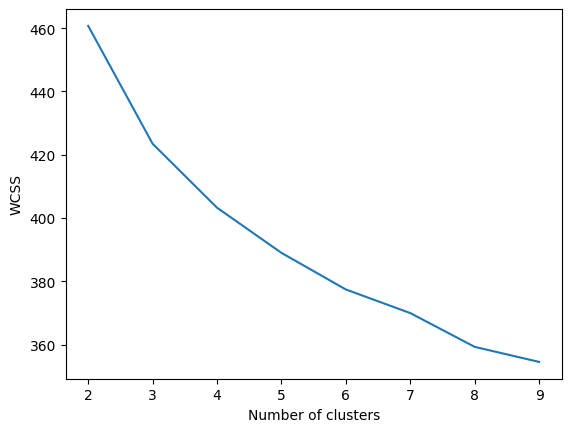

In [ ]:
# Plot Elbow
plt.plot(n_clusters_range, wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<Axes: xlabel='PC1', ylabel='PC2'>

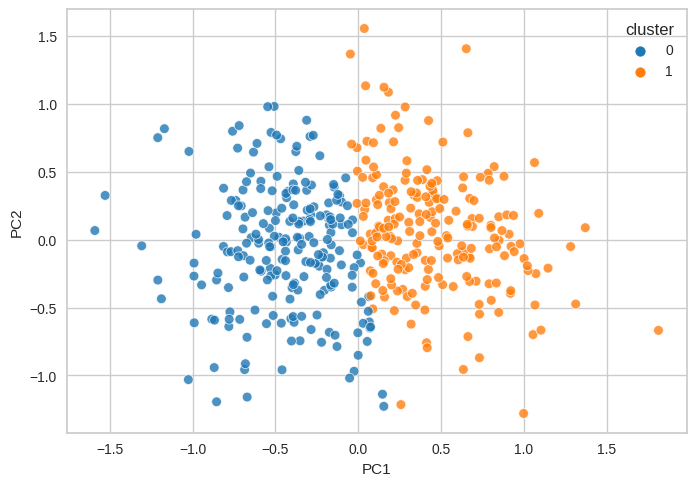

In [ ]:
# Create K-Means Cluster Model
from sklearn.decomposition import PCA

seed = 1234 # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# 2 components visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette='tab10', alpha=0.8)

In [ ]:
pca_data.to_excel('before_skills_clusters.xlsx', index=False) # to be used for comparison in personality notebook

#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid
# Create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:01<00:00,  6.00it/s, max_LL=-1.99e+3, max_avg_LL=-4.69]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 34 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.9008 0.0992 0.0000 0.0000 0.0000 0.9704 0.0296 0.0000 0.0000 0.0000
 0.6985 0.3015 0.0000 0.0000 0.0000 0.7776 0.2224 0.0000 0.0000 0.0000
 0.6731 0.3269 0.0000 0.0000 0.0000 0.7500 0.2500 0.0000 0.0000 0.0000
 0.8541 0.1459 0.0000 0.0000 0.0000 0.7335 0.2665 0.0000 0.0000 0.0000
 0.8373 0.1627 0.0000 0.0000 0.0000 0.8226 0.1774 0.0000 0.0000 0.0000
 0.8492 0.1508 0.0000 0.0000 0.0000 0.9342 0.0658 0.0000 0.0000 0.0000
 0.8143 0.1857 0.0000 0.0000 0.0000 0.9112 0.0888 0.0000 0.0000 0.0000
 0.8964 0.1036 0.0000 0.0000 0.0000 0.6557 0.3443 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:19<00:00,  1.96s/it, max_LL=-1.94e+3, max_avg_LL=-4.59]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 34 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.9980 0.0020 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.9737 0.0263 0.0000 0.0000 0.0000 0.9962 0.0038 0.0000 0.0000 0.0000
 0.9768 0.0232 0.0000 0.0000 0.0000 0.9954 0.0046 0.0000 0.0000 0.0000
 0.9967 0.0033 0.0000 0.0000 0.0000 0.9980 0.0020 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.9949 0.0051 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.9901 0.0099 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:27<00:00,  2.77s/it, max_LL=-1.9e+3, max_avg_LL=-4.5]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 34 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.9894 0.0106 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.8937 0.1063 0.0000 0.0000 0.0000 0.9569 0.0431 0.0000 0.0000 0.0000
 0.8036 0.1964 0.0000 0.0000 0.0000 0.9661 0.0339 0.0000 0.0000 0.0000
 0.9841 0.0159 0.0000 0.0000 0.0000 0.9769 0.0231 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.9378 0.0622 0.0000 0.0000 0.0000
 0.9616 0.0384 0.0000 0.0000 0.0000 0.9488 0.0512 0.0000 0.0000 0.0000
 0.8824 0.1176 0.0000 0.0000 0.0000 0.9802 0.0198 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.9236 0.0764 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:50<00:00,  5.04s/it, max_LL=-1.88e+3, max_avg_LL=-4.43]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 34 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.8662 0.1338 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.5960 0.4040 0.0000 0.0000 0.0000 0.6893 0.3107 0.0000 0.0000 0.0000
 0.6033 0.3967 0.0000 0.0000 0.0000 0.5543 0.4457 0.0000 0.0000 0.0000
 0.9107 0.0893 0.0000 0.0000 0.0000 0.6468 0.3532 0.0000 0.0000 0.0000
 0.7369 0.2631 0.0000 0.0000 0.0000 0.8208 0.1792 0.0000 0.0000 0.0000
 0.8234 0.1766 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.8268 0.1732 0.0000 0.0000 0.0000 0.9126 0.0874 0.0000 0.0000 0.0000
 0.6940 0.3060 0.0000 0.0000 0.0000 0.1522 0.8478 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [01:07<00:00,  6.73s/it, max_LL=-1.85e+3, max_avg_LL=-4.37]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 34 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.9848 0.0152 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.8741 0.1259 0.0000 0.0000 0.0000 0.9421 0.0579 0.0000 0.0000 0.0000
 0.7213 0.2787 0.0000 0.0000 0.0000 0.9654 0.0346 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.9465 0.0535 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.9845 0.0155 0.0000 0.0000 0.0000
 0.9690 0.0310 0.0000 0.0000 0.0000 0.8702 0.1298 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [00:59<00:00,  5.98s/it, max_LL=-1.83e+3, max_avg_LL=-4.33]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 34 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.8936 0.1064 0.0000 0.0000 0.0000 0.9477 0.0523 0.0000 0.0000 0.0000
 0.2892 0.7108 0.0000 0.0000 0.0000 0.3976 0.6024 0.0000 0.0000 0.0000
 0.6210 0.3790 0.0000 0.0000 0.0000 0.6507 0.3493 0.0000 0.0000 0.0000
 0.6803 0.3197 0.0000 0.0000 0.0000 0.4104 0.5896 0.0000 0.0000 0.0000
 0.7314 0.2686 0.0000 0.0000 0.0000 0.8387 0.1613 0.0000 0.0000 0.0000
 0.8935 0.1065 0.0000 0.0000 0.0000 0.9423 0.0577 0.0000 0.0000 0.0000
 0.6849 0.3151 0.0000 0.0000 0.0000 0.7380 0.2620 0.0000 0.0000 0.0000
 0.9467 0.0533 0.0000 0.0000 0.0000 0.4614 0.5386 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [01:19<00:00,  7.98s/it, max_LL=-1.81e+3, max_avg_LL=-4.28]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 34 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.9405 0.0595 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.3368 0.6632 0.0000 0.0000 0.0000 0.5896 0.4104 0.0000 0.0000 0.0000
 0.6245 0.3755 0.0000 0.0000 0.0000 0.8095 0.1905 0.0000 0.0000 0.0000
 0.9359 0.0641 0.0000 0.0000 0.0000 0.8355 0.1645 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.6372 0.3628 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000


Initializations (n_init) : 100%|██████████| 10/10 [01:15<00:00,  7.55s/it, max_LL=-1.79e+3, max_avg_LL=-4.24]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 34 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.9643 0.0357 0.0000 0.0000 0.0000 0.9913 0.0087 0.0000 0.0000 0.0000
 0.9807 0.0193 0.0000 0.0000 0.0000 0.9963 0.0037 0.0000 0.0000 0.0000
 0.9934 0.0066 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.9961 0.0039 0.0000 0.0000 0.0000
 0.9935 0.0065 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.9731 0.0269 0.0000 0.0000 0.0000


In [ ]:
results

,param_n_steps,param_n_components,aic,bic
0,1,2,4632.033829,5971.714020
1,1,3,4873.984591,6885.528564
2,1,4,5129.874311,7813.282066
3,1,5,5408.903735,8764.175271
4,1,6,5688.603491,9715.738809
5,1,7,5981.341704,10680.340804
6,1,8,6271.261186,11642.124068
7,1,9,6574.731029,12617.457692
